1. Опишите  трихроматическую  теорию  цветовосприятия  и  её  значение  для 
компьютерного  зрения.  Как  трихроматическая  теория  связана  с  моделями 
представления  цвета,  такими  как  RGB,  HSB,  и  Lab?  В  чем  заключаются 
преимущества и недостатки использования каждой из этих моделей для анализа 
и обработки изображений?

2. Напишите  скрипт  на  Python,  который  использует  RANSAC  для  нахождения 
модели прямой на зашумлённых данных. 


Трихономическая теория - человеческий глаз содержит три типа колбочек, чувствительных к синему, зелёному и красному диапазонам спектра. 

Значение для компьютерного зрения:

- Объясняет, почему достаточно трёх каналов (R, G, B) для кодирования цвета в цифровых изображениях.
- Лежит в основе большинства цветовых моделей, имитирующих человеческое восприятие.

| Модель      | Преимущества                                                                 | Недостатки                                                                 |
|-------------|------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **RGB**     | - Идеальна для отображения на экранах.<br>- Проста в обработке аппаратурой. | - Яркость и цвет смешаны.<br>- Неинтуитивна для цветокоррекции.            |
| **HSB/HSV** | - Удобна для ручной коррекции (тон, насыщенность, яркость разделены).<br>- Подходит для сегментации по цвету. | - Неравномерное распределение цветов.<br>- Сложности при конвертации в RGB. |
| **Lab**     | - Яркость (L) отделена от цвета (a, b).<br>- Равномерное цветовое пространство, близкое к восприятию человека. | - Вычислительно затратна.<br>- Сложна для интерпретации без инструментов.  |

In [11]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression

X, y = make_regression(
    n_samples=200, 
    n_features=2, 
    noise=4.0, 
    random_state=0
)

reg = RANSACRegressor(random_state=0).fit(X, y)
reg.score(X, y)
reg.predict(X[:1,])

array([-31.94170869])

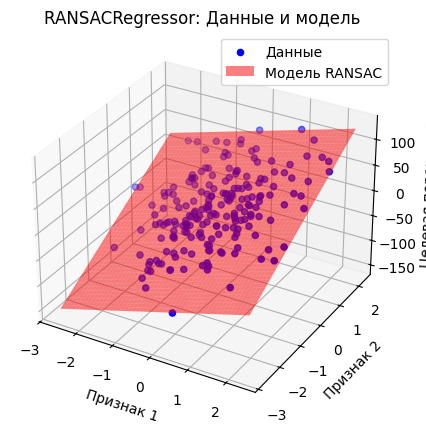

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Данные')


x0, x1 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 50),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 50))

y_pred = reg.estimator_.intercept_ + reg.estimator_.coef_[0] * x0 + reg.estimator_.coef_[1] * x1
ax.plot_surface(x0, x1, y_pred, color='red', alpha=0.5, label='Модель RANSAC')

ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Целевая переменная')
ax.set_title('RANSACRegressor: Данные и модель')
plt.legend()
plt.show()

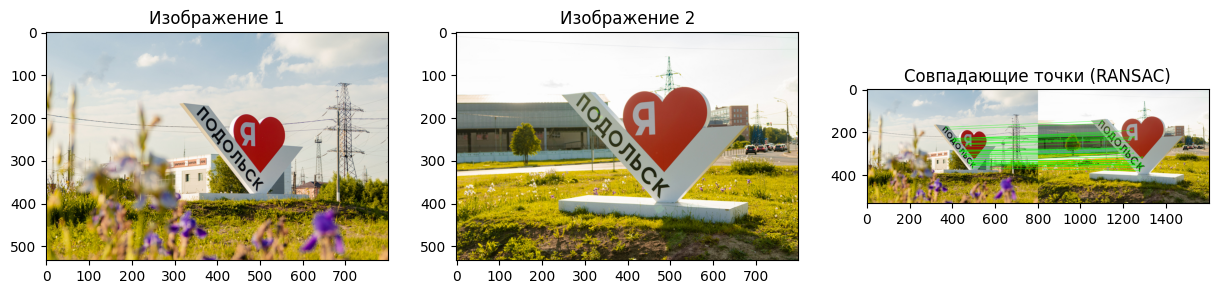

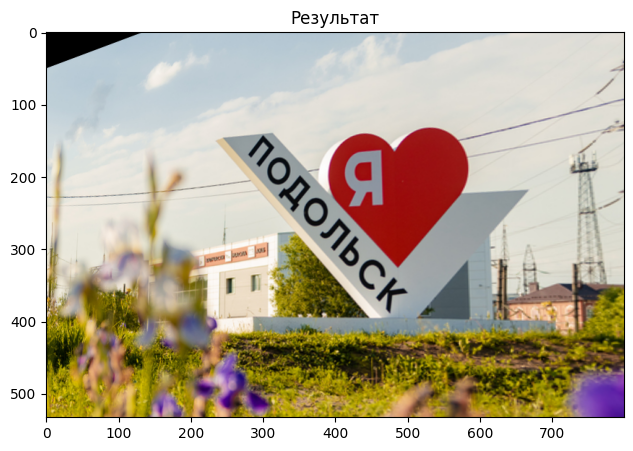

In [13]:
import cv2

image1 = cv2.imread('./data/RANSAC/RANSAC1.jpg')
image2 = cv2.imread('./data/RANSAC/RANSAC2.jpg')

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    height, width, channels = image2.shape
    warped_image = cv2.warpPerspective(image1, H, (width, height))

    matches_mask = mask.ravel().tolist()
    draw_params = dict(
        matchColor=(0, 255, 0),
        singlePointColor=None,
        matchesMask=matches_mask,
        flags=2
    )
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, **draw_params)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.title('Изображение 1')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.title('Изображение 2')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title('Совпадающие точки (RANSAC)')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title('Результат')
    plt.show()